In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras

/Users/maxwood/opt/miniconda3/envs/deep_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (300, 300)

In [3]:
data_dir = pathlib.Path('my_data')
img_height = 300
img_width = 300
batch_size = 32

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8183 files belonging to 6 classes.
Using 6547 files for training.


2022-06-15 17:54:45.453565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8183 files belonging to 6 classes.
Using 1636 files for validation.


In [6]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 4)
val_ds = val_ds.skip(val_batches // 4)

In [7]:
class_names = train_ds.class_names
print(class_names)

['country', 'holiday', 'jazz', 'latin', 'rap', 'rock']


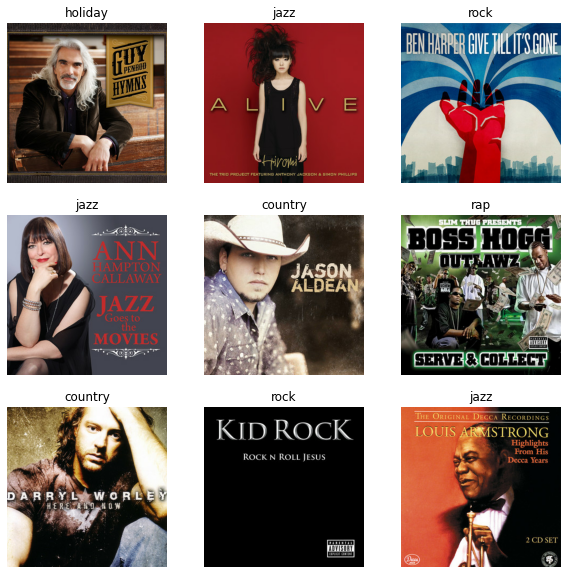

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Base Model

Start without transfer learning or drop out

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
205/205 [==============================] - 171s 833ms/step - loss: 1.7611 - accuracy: 0.2765 - val_loss: 1.6563 - val_accuracy: 0.3213
Epoch 2/5
205/205 [==============================] - 168s 820ms/step - loss: 1.5636 - accuracy: 0.3773 - val_loss: 1.5462 - val_accuracy: 0.3869
Epoch 3/5
205/205 [==============================] - 168s 822ms/step - loss: 1.3187 - accuracy: 0.4963 - val_loss: 1.5677 - val_accuracy: 0.3975
Epoch 4/5
205/205 [==============================] - 167s 813ms/step - loss: 0.9082 - accuracy: 0.6661 - val_loss: 1.8491 - val_accuracy: 0.3992
Epoch 5/5
127/205 [=================>............] - ETA: 1:01 - loss: 0.5796 - accuracy: 0.7955

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
y_prob = model.predict(val_ds)

In [ ]:
y_predict = y_prob.argmax(axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay.from_predictions(y_actual,y_predict,
                               display_labels=class_names, xticks_rotation = 'vertical')

Hmm Pretty bad :(, looks like we're overfitting a bit. Perhapps dropout can help.

### With Dropout added to our model

In [ ]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.80, seed = 123),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

In [ ]:
model.summary()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 4)
plt.plot(val_acc, label='Validation Accuracy',linewidth = 4)
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
#plt.title('Training and Validation Accuracy')

plt.xlabel('epoch')
plt.show()


In [ ]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay.from_predictions(y_actual,y_predict,
                               display_labels=class_names, xticks_rotation = 'vertical')

### Transfer Learning

In [16]:
# most of this is copied from and changed to match my problem
#https://www.tensorflow.org/tutorials/images/transfer_learning
# Create the base model from the pre-trained model MobileNet V2

BATCH_SIZE = 32
IMG_SIZE = (300, 300)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [18]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 3, 3, 5, 0, 0, 2, 0, 2, 3, 2, 5, 5, 0, 5, 0, 4, 0, 5, 4, 5, 5,
       4, 5, 5, 4, 3, 1, 5, 1, 5, 3], dtype=int32)>

In [19]:
base_model.trainable = False

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 75, 75, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 77, 77, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 38, 38, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 38, 38, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 19, 19, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 19, 19, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 19, 19, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 19, 19, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 19, 19, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 19, 19, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 19, 19, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 19, 19, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 10, 10, 960)  8640       ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 10, 10, 960)  3840       ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 10, 10, 960)  0          ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 10, 10, 160)  153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation = 'relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


In [23]:
base_conainter = tf.keras.Sequential([])

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [25]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = base_conainter(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                             

In [28]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(val_ds)

39/39 [==============================] - 24s 598ms/step - loss: 1.7613 - accuracy: 0.2434


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.76
initial accuracy: 0.24


In [30]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
205/205 [==============================] - 149s 718ms/step - loss: 1.7468 - accuracy: 0.2707 - val_loss: 1.6858 - val_accuracy: 0.3156
Epoch 2/20
205/205 [==============================] - 149s 726ms/step - loss: 1.6948 - accuracy: 0.3183 - val_loss: 1.6219 - val_accuracy: 0.3623
Epoch 3/20
205/205 [==============================] - 148s 723ms/step - loss: 1.6413 - accuracy: 0.3544 - val_loss: 1.5756 - val_accuracy: 0.3918
Epoch 4/20
205/205 [==============================] - 146s 714ms/step - loss: 1.6010 - accuracy: 0.3770 - val_loss: 1.5410 - val_accuracy: 0.4123
Epoch 5/20
205/205 [==============================] - 147s 718ms/step - loss: 1.5800 - accuracy: 0.3935 - val_loss: 1.5170 - val_accuracy: 0.4131
Epoch 6/20
205/205 [==============================] - 147s 716ms/step - loss: 1.5495 - accuracy: 0.4063 - val_loss: 1.4986 - val_accuracy: 0.4230
Epoch 7/20
205/205 [==============================] - 146s 711ms/step - loss: 1.5363 - accuracy: 0.4121 - val_loss: 1.4855 -

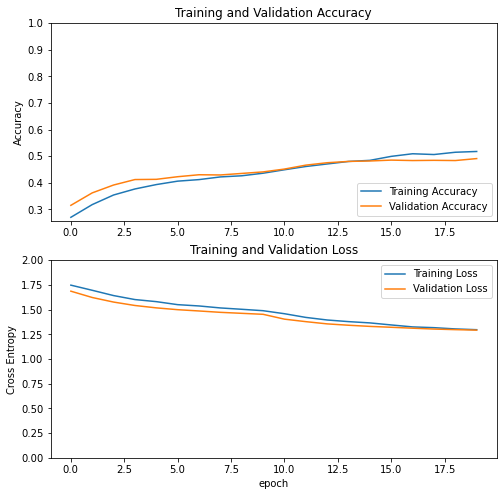

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

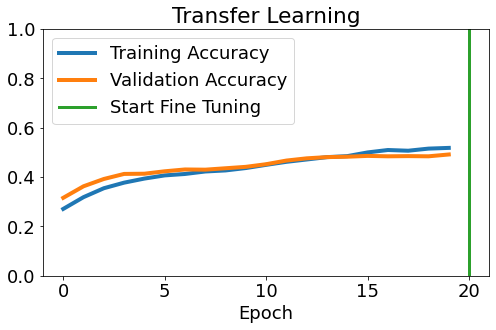

In [32]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 4)
plt.plot(val_acc, label='Validation Accuracy', linewidth = 4)
plt.ylim([0, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning', linewidth = 3)
plt.legend(loc='upper left')
plt.title('Transfer Learning')

#plt.subplot(2, 1, 2)
#plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 2.0])
#plt.plot([initial_epochs-1,initial_epochs-1],
#         plt.ylim(), label='Start Fine Tuning')
#plt.legend(loc='upper right')
plt.title('Transfer Learning')
plt.xlabel('Epoch')
plt.show()

In [33]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

39/39 [==============================] - 25s 622ms/step


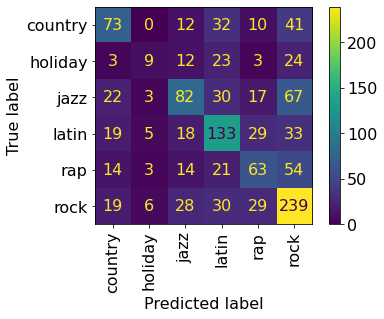

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay.from_predictions(y_actual,y_predict,
                               display_labels=class_names, xticks_rotation = 'vertical')

# Evaluate Test pre Fine tuning

I know that fine tuning will overfit the model (from previous runs) so I'm going to test things here



In [44]:
y_actual_t = np.concatenate([y for x, y in test_ds], axis=0)
y_prob_t = model.predict(test_ds)
y_predict_t = y_prob_t.argmax(axis=-1)

13/13 [==============================] - 9s 631ms/step


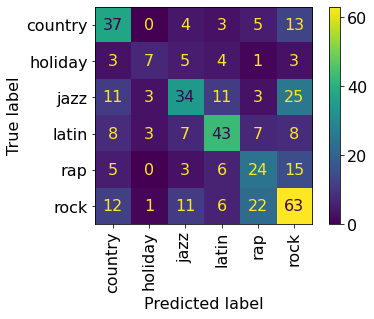

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual_t, y_predict_t)
disp = ConfusionMatrixDisplay.from_predictions(y_actual_t,y_predict_t,
                               display_labels=class_names, xticks_rotation = 'vertical')

### Fine Tuning

In [47]:
base_model.trainable = True

In [48]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [49]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                             

In [51]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
205/205 [==============================] - 274s 1s/step - loss: 1.2408 - accuracy: 0.5351 - val_loss: 1.2452 - val_accuracy: 0.5262
Epoch 21/30
205/205 [==============================] - 257s 1s/step - loss: 1.1413 - accuracy: 0.5749 - val_loss: 1.2046 - val_accuracy: 0.5426
Epoch 22/30
205/205 [==============================] - 264s 1s/step - loss: 1.0685 - accuracy: 0.6084 - val_loss: 1.1857 - val_accuracy: 0.5623
Epoch 23/30
205/205 [==============================] - 253s 1s/step - loss: 0.9977 - accuracy: 0.6316 - val_loss: 1.1669 - val_accuracy: 0.5598
Epoch 24/30
205/205 [==============================] - 257s 1s/step - loss: 0.9323 - accuracy: 0.6550 - val_loss: 1.1560 - val_accuracy: 0.5639
Epoch 25/30
205/205 [==============================] - 249s 1s/step - loss: 0.8647 - accuracy: 0.6895 - val_loss: 1.1493 - val_accuracy: 0.5713
Epoch 26/30
205/205 [==============================] - 243s 1s/step - loss: 0.8210 - accuracy: 0.7026 - val_loss: 1.1378 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 4)
plt.plot(val_acc, label='Validation Accuracy', linewidth = 4)
plt.ylim([0, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning', linewidth = 3)
plt.legend(loc='upper left')
plt.title('Transfer Learning')

#plt.subplot(2, 1, 2)
#plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 2.0])
#plt.plot([initial_epochs-1,initial_epochs-1],
#         plt.ylim(), label='Start Fine Tuning')
#plt.legend(loc='upper right')
plt.title('Transfer Learning')
plt.xlabel('Epoch')
plt.show()

In [ ]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay.from_predictions(y_actual,y_predict,
                               display_labels=class_names, xticks_rotation = 'vertical')

# Test Evalutation

In [ ]:
# For fun lets see how we would have done post fine tuning

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

In [ ]:
y_actual_t = np.concatenate([y for x, y in test_ds], axis=0)
y_prob_t = model.predict(test_ds)
y_predict_t = y_prob_t.argmax(axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual_t, y_predict_t)
disp = ConfusionMatrixDisplay.from_predictions(y_actual_t,y_predict_t,
                               display_labels=class_names, xticks_rotation = 'vertical')